In [30]:
import fenics as fn
import numpy as np
import matplotlib.pyplot as plt
from dolfin_utils.meshconvert import meshconvert
import os
from subprocess import call

In [31]:
def curl2D(v):
    return fn.as_vector((v.dx(1),-v.dx(0)))

class FEM():
            
    def __init__(self,rhs=100,c1=1.0,c2=100.0, meshsize = 0.05, verb = False):
        path='./'
        
        with open(path + 'slice.geo', 'r') as file:
            data = file.read()
            
        s = "meshsize=%.18f;\n"%(meshsize)
        
        s = s + data
        
        with  open(path+"tmp.geo", "w") as file:
            file.write(s)
            file.close()
        if verb: print('geo file created',flush = True)
        
        if verb:
            os.system('gmsh %stmp.geo -nt 20 -3 -o %stmp.msh -format msh2 '%(path,path))
        else:
            os.system('gmsh %stmp.geo -nt 20 -3 -o %stmp.msh -format msh2 >/dev/null 2>&1'%(path,path))
        if verb: print('mesh file created',flush=True)

        if verb:
            os.system('dolfin-convert %stmp.msh %stmp.xml'%(path,path))
        else:
            os.system('dolfin-convert %stmp.msh %stmp.xml >/dev/null 2>&1'%(path,path))
        
        if verb: print('mesh file converted in fenics format',flush=True) 

        mesh = fn.Mesh(path+'tmp.xml')
        domains = fn.MeshFunction("size_t", mesh, path+'tmp_physical_region.xml')
        boundaries = fn.MeshFunction('size_t', mesh, path+'tmp_facet_region.xml')

        self.mesh = mesh
        ncells = [  mesh.num_vertices(), mesh.num_edges(), mesh.num_faces(), mesh.num_facets(), mesh.num_cells() ]
        
        
        def nonlin(u):
            
            return c2
        
        
        # Coil
        def setup_coil(mesh,subdomains):
            DG = fn.FunctionSpace(mesh,"DG",0)
            J = fn.Function(DG)
            idx = []
            for cell_no in range(len(subdomains.array())):
                subdomain_no = subdomains.array()[cell_no]
                if subdomain_no == 11:
                    idx.append(cell_no)
            J.vector()[:] = 0
            J.vector()[idx] = rhs
            return J
        
    
        
        """ define function space and boundary conditions"""
        
        CG = fn.FunctionSpace(mesh, 'CG', 1) # Continuous Galerkin
        
        # Define boundary condition
        bc = fn.DirichletBC(CG, fn.Constant(0.0), boundaries,10)
        
        # Define subdomain markers and integration measure
        dx = fn.Measure('dx', domain=mesh, subdomain_data=domains)
        
        J = setup_coil(mesh, domains)
        
        class Coefficient(fn.UserExpression): # UserExpression instead of Expression
            def __init__(self, markers, **kwargs):
                super().__init__(**kwargs) # This part is new!
                self.markers = markers
            def eval_cell(self, values, x, cell):
                if self.markers[cell.index] == 11:
                    values[0] = 0.0   # iron
                elif self.markers[cell.index] == 12:
                    values[0] = c1      # air

                else:
                    print('no such domain',self.markers[cell.index] )
                    
        coeff = Coefficient(domains, degree=1)
        
        
        """ weak formulation """
        
        az  = fn.Function(CG)
        u  = fn.Function(CG)
        v  = fn.TestFunction(CG)
        #az = Function(CG)
        #a  = (1/mu)*dot(grad(az), grad(v))*dx
        a = fn.inner(coeff*fn.grad(u), fn.grad(v))*dx + fn.inner(nonlin(fn.grad(u))*fn.grad(u),fn.grad(v))*dx(11)
        L  = J*v*dx(11)
        
        F = a - L
        # solve variational problem
        fn.solve(F == 0, u, bc)
        az = u
        self.az = az
        # function space for H- and B- field allocated on faces of elements
        W = fn.VectorFunctionSpace(mesh, fn.FiniteElement("DP", fn.triangle, 0),1)
        self.G = fn.project(fn.grad(az), W)
        
    
        
    
    def __call__(self,x_eval,y_eval):
        
        
        Afem = 0 * x_eval
        for i in range(x_eval.size):
            try:
                Afem[i] = self.az(x_eval[i],y_eval[i])
            except:
                Afem[i] = np.nan
        return Afem
    
    def grad(self,x_eval,y_eval):
        
        
        Gfem = []
        for i in range(x_eval.size):
            try:
                Gfem.append(self.G(x_eval[i],y_eval[i]))
            except:
                Gfem.append([ np.nan , np.nan])
        return np.array(Gfem)
    

    No Jacobian form specified for nonlinear variational problem.
    Differentiating residual form F to obtain Jacobian J = F'.
    Solving nonlinear variational problem.
      Newton iteration 0: r (abs) = 3.000e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
      Newton iteration 1: r (abs) = 7.015e-14 (tol = 1.000e-10) r (rel) = 2.338e-14 (tol = 1.000e-09)
      Newton solver finished in 1 iterations and 1 linear solver iterations.
    Building point search tree to accelerate distance queries.
    Computed bounding box tree with 6127 nodes for 3064 points.


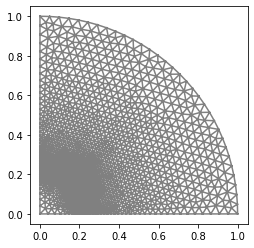

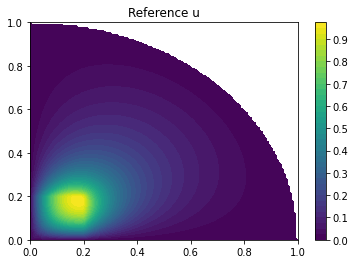

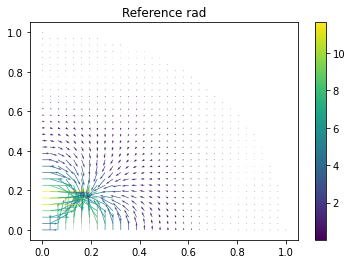

In [39]:

fem = FEM(rhs = 1000, c1 = 1, c2= 10)

x_mesh, y_mesh = np.meshgrid(np.linspace(0,1,128),np.linspace(0,1,128))

u_ref = fem(x_mesh.flatten(),y_mesh.flatten()).reshape(x_mesh.shape)

# plt.figure()
# plt.contourf(x_mesh,y_mesh,A,levels=64)
# plt.colorbar()
# plt.title('NN result')

plt.figure()
fn.plot(fem.mesh)

plt.figure()
plt.contourf(x_mesh,y_mesh,u_ref,levels=42)
plt.colorbar()
plt.title('Reference u')

x_mesh, y_mesh = np.meshgrid(np.linspace(0,1,32),np.linspace(0,1,32))

G_ref = fem.grad(x_mesh.flatten(),y_mesh.flatten())


plt.figure()
plt.quiver(x_mesh.flatten(),y_mesh.flatten(),G_ref[:,0],G_ref[:,1],np.sqrt(G_ref[:,0]**2+G_ref[:,1]**2))
plt.colorbar()
plt.title('Reference rad')


plt.show()